# Preprocessing

## 1. Importing necessary libraries and data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
sys.path = list(dict.fromkeys(sys.path))

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

Primary check-ups

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
missing_df = pd.DataFrame(train.isnull().sum(), columns = ['missing_count'])
missing_df['missing_percentage'] = missing_df['missing_count'].apply(lambda x: round(x * 100/train.shape[0], 2))
print(missing_df)


             missing_count  missing_percentage
PassengerId              0                0.00
Survived                 0                0.00
Pclass                   0                0.00
Name                     0                0.00
Sex                      0                0.00
Age                    177               19.87
SibSp                    0                0.00
Parch                    0                0.00
Ticket                   0                0.00
Fare                     0                0.00
Cabin                  687               77.10
Embarked                 2                0.22


In [5]:
print(train.describe(include = 'all'))

        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare 

check list
- Age, Cabin, Embarked has missing values (missing at random? especially Age and Cabin)
- Age, SibSp, Parch, Fare all right-skewed. Would it be better to replace them with categorical variables instead?
- Title (e.g. Mr., Mrs.) is included in Name. Can this help?
- Pclass: keep as ordinal or categorical?
- Explore Cabin column (top value looks unusual)
- Ticket is not unique for all passengers
- Sex has unique values of 2. change it to int

## 2. Missing Data Analysis

#### 1. Embarked

In [6]:
train.loc[train['Embarked'].isna()]

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

In [7]:
train.loc[train['Ticket']=='113572']

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

In [8]:
train.loc[train['Cabin']=='B28']

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


- Embarked : only missing in train data. Will drop these rows
- Age : some missing data for both train and test data. Will need to check if missingness is meaningful
- Cabin : majority of the data is missing. Will also need to check if missingness is meaningful
- Fare : one row missing in test data. Will use similar imputation method as Age

In [10]:
train = train.loc[~train['Embarked'].isna()]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


## 3. Feature Engineering

In [11]:
feature_func = []

#### 1. extracting titles from Name

In [12]:
def get_name_title(X):
    X = X.copy()
    X['name_title'] = [re.search(r", (.*?)\.", x).group(1) for x in X.iloc[:,0]]
    return X[['name_title']].astype('category')

train['name_title'] = get_name_title(train[['Name']])
train['name_title'].value_counts()


name_title
Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: count, dtype: int64

#### 1a) name_title to special_title_flg (0=generic (Mr, Mrs, Miss, Ms), 1=special (Sir, Master, ...))

In [13]:
def get_special_title_flg(X):
    X = get_name_title(X)
    X['special_title_flg'] = ['generic' if x in ['Mr', 'Miss', 'Mrs', 'Ms'] else 'special' for x in X.iloc[:,0]]
    return X[['special_title_flg']].astype('category')

train['special_title_flg'] = get_special_title_flg(train[['Name']])
train['special_title_flg'].value_counts()

special_title_flg
generic    823
special     66
Name: count, dtype: int64

In [14]:
feature_func.append(('get_special_title_flg', 'Name'))

In [15]:
feature_func.append(('get_name_title', 'Name'))

#### 2) family_flg
- SibSp=0 & Parch=0 -> "no_fam"
- SibSp>0 & Parch=0 -> "SibSp"
- SibSp=0 & Parch>0 -> "Parch"
- SibSp>0 & Parch>0 -> "big_fam"

In [16]:

def get_family_flg(X):
    def family_onboard(X):
        if X['SibSp'] == 0 and X['Parch'] == 0:
            return 'no_fam'
        elif X['SibSp'] > 0 and X['Parch'] == 0:
            return 'SibSp'
        elif X['SibSp'] == 0 and X['Parch'] > 0:
            return 'Parch'
        elif X['SibSp'] > 0 and X['Parch'] > 0:
            return 'big_fam'
        else:
            return 'NA'
    X = X.copy()
    X['family_flg'] = X.apply(lambda x: family_onboard(x), axis=1)
    return X[['family_flg']].astype('category')

train['family_flg'] = get_family_flg(train[['SibSp','Parch']])
train['family_flg'].value_counts()

family_flg
no_fam     535
big_fam    142
SibSp      141
Parch       71
Name: count, dtype: int64

In [17]:
feature_func.append(('get_family_flg', ['SibSp','Parch']))

#### 3) Cabin
First need to explore the data values

In [18]:
train['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
E101           3
C22 C26        3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 146, dtype: int64

#### 3a) cabin_count
Looks like Cabin column consist of alpha-numerical values. It also looks like multiple rooms were assigned to some passengers. Rooms separated by space. Will create 'cabin_count' based on this info

In [19]:
# def get_cabin_count(X):
#     X = X.copy()
#     X['cabin_count'] = [0 if x is np.nan else len(x.split(' ')) for x in X.iloc[:,0]]
#     return X[['cabin_count']]

def get_cabin_count(X):
    X = X.copy()
    X['cabin_count'] = X.iloc[:, 0].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    return X[['cabin_count']]


train['cabin_count'] = get_cabin_count(train[['Cabin']])
train['cabin_count'].value_counts()

cabin_count
0    687
1    178
2     16
3      6
4      2
Name: count, dtype: int64

In [20]:
feature_func.append(('get_cabin_count', 'Cabin'))

#### 3b) cabin_flg
since only a few passengers are assigned to more than 3 cabins, could be better to create 'cabin_flg' where:
- cabin_count=0 -> "no_cabin"
- cabin_count=1 -> "one_cabin"
- cabin_count>1 -> "many_cabins"

In [21]:
def get_cabin_flg(X):
    X = get_cabin_count(X)
    X['cabin_flg'] = ["no_cabin" if x==0 else "one_cabin" if x==1 else "many_cabins" for x in X.iloc[:,0]]
    return X[['cabin_flg']].astype('category')

train['cabin_flg'] = get_cabin_flg(train[['Cabin']])
train['cabin_flg'].value_counts()

cabin_flg
no_cabin       687
one_cabin      178
many_cabins     24
Name: count, dtype: int64

there are too little data points for many_cabins. should cabin_flg be "has cabin/doesn't have cabin" feature instead?

need to check the data count against the target

In [22]:
import scipy.stats as stats
ct = pd.crosstab(train['cabin_flg'], train['Survived'])
print(ct)
res = stats.chi2_contingency(ct)
print(res.expected_freq)
print(res.pvalue)

Survived       0    1
cabin_flg            
many_cabins   10   14
no_cabin     481  206
one_cabin     58  120
[[ 14.82114736   9.17885264]
 [424.25534308 262.74465692]
 [109.92350956  68.07649044]]
7.494156151524445e-20


cabin_flg seems significant in predicting the survival. 
and since many_cabins and one_cabin seem to have same trend (more leaned toward survived) so it could be better to combine the two field and go with "has cabin/ doesn't have cabin" feature


In [23]:
def get_cabin_flg(X):
    X = X.copy()
    X['cabin_flg'] = ["no_cabin" if x is np.nan else "has_cabin" for x in X.iloc[:,0]]
    return X[['cabin_flg']].astype('category')

train['cabin_flg'] = get_cabin_flg(train[['Cabin']])
train['cabin_flg'].value_counts()

cabin_flg
no_cabin     687
has_cabin    202
Name: count, dtype: int64

In [24]:
feature_func.append(('get_cabin_flg', 'Cabin'))

#### 3c) cabin_share_flg
Looks like some cabins are shared between passengers. Will create 'cabin_share_flg' where:
- passenger_count=1 -> "private"
- passenger_count>1 -> "shared"
- no cabin -> "no_cabin"

In [25]:
def get_cabin_share_flg(X):
    count_df = X.value_counts()
    merged = pd.merge(X, count_df, how='left', on=['Cabin'])
    merged['cabin_share_flg'] = ["private" if x==1 else "shared" if x>1 else 'no_cabin' for x in merged.iloc[:,-1]]
    return merged[['cabin_share_flg']].astype('category')

train['cabin_share_flg']=get_cabin_share_flg(train[['Cabin']])
train['cabin_share_flg'].value_counts()

cabin_share_flg
no_cabin    686
private     101
shared      100
Name: count, dtype: int64

In [26]:
feature_func.append(('get_cabin_share_flg', 'Cabin'))

#### 4) Ticket
Check which ticket number is being repeated

In [27]:
def get_ticket_share_flg(X):
    count_df = X.iloc[:,0].value_counts()
    merged = X.merge(count_df, how='left', on=['Ticket']).set_index(X.index)
    merged['ticket_share_flg'] = ['unshared' if x==1 else 'shared' for x in merged.iloc[:,-1]]
    return merged[['ticket_share_flg']].astype('category')

train['ticket_share_flg'] = get_ticket_share_flg(train[['Ticket']])
train['ticket_share_flg'].value_counts()

ticket_share_flg
unshared    547
shared      342
Name: count, dtype: int64

check list
- is ticket_share_flg related to 
    - family_flg?
    - cabin_flg?
    - cabin_share_flg?

In [28]:
feature_func.append(('get_ticket_share_flg', 'Ticket'))

In [29]:
pd.crosstab(train['ticket_share_flg'],train['family_flg'], normalize='all')

family_flg           Parch     SibSp   big_fam    no_fam
ticket_share_flg                                        
shared            0.057368  0.098988  0.146232  0.082115
unshared          0.022497  0.059618  0.013498  0.519685

In [30]:
pd.crosstab(train['ticket_share_flg'],train['cabin_flg'], normalize='all')

cabin_flg         has_cabin  no_cabin
ticket_share_flg                     
shared             0.127109  0.257593
unshared           0.100112  0.515186

In [31]:
pd.crosstab(train['ticket_share_flg'],train['cabin_share_flg'], normalize='all')

cabin_share_flg   no_cabin   private    shared
ticket_share_flg                              
shared            0.301015  0.038331  0.046223
unshared          0.472379  0.075536  0.066516

It can be seens that proportion of shared tickets were the highest at 
- family_flg=big_fam
- cabin_flg=no_cabin
- cabin_share_flg=no_cabin

The imbalance of no_cabin to other values in 'cabin_flg' and 'cabin_share_flg' could be the reason behind this result.

Could be benefitial to explore the interaction between these flg columns.

#### 5) age_flg

Fair amount of Age data is missing. Need to check if the missingness has any meaning

In [32]:
def get_age_flg(X):
    X = X.copy()
    X['age_flg'] = ['0' if np.isnan(x) else '1' for x in X.iloc[:,0]]
    return X[['age_flg']].astype('category')

train['age_flg'] = get_age_flg(train[['Age']])
train['age_flg'].value_counts()

age_flg
1    712
0    177
Name: count, dtype: int64

In [33]:
feature_func.append(('get_age_flg', 'Age'))

#### 6) fare_flg
It seems there are passengers who paid 0 for their Fare.
Check how many actually went onboard with no charge

In [34]:
def get_fare_flg(X):
    X = X.copy()
    X['fare_flg'] = ['free' if x==0 else 'paid' for x in X.iloc[:,0]]
    return X[['fare_flg']].astype('category')

train['fare_flg'] = get_fare_flg(train[['Fare']])
train['fare_flg'].value_counts(normalize='column')

fare_flg
paid    0.983127
free    0.016873
Name: proportion, dtype: float64

Only 1.6% of the passengers had 0 Fare, so no special flag will be assigned and will be treated as low fare


Fare will be divided in to 3 equal-sized bin and assign fare_flg based on the bin interval:
- Fare in the first price range -> "low"
- Fare in the middle price range -> " mid"
- Fare in the last price range -> "high"

In [35]:
def get_fare_flg(X):
    X = X.copy()
    X['fare_flg'] = pd.qcut(X.iloc[:,0], q=3, labels=['low', 'mid', 'high'])
    return X[['fare_flg']]

train['fare_flg'] = get_fare_flg(train[['Fare']])
train['fare_flg'].value_counts()

fare_flg
low     308
high    293
mid     288
Name: count, dtype: int64

<Axes: xlabel='fare_flg', ylabel='count'>

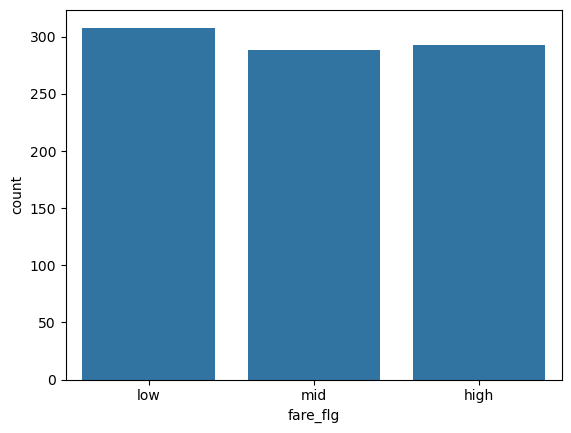

In [36]:
sns.barplot(train['fare_flg'].value_counts()[:20])

In [37]:
feature_func.append(('get_fare_flg', 'Fare'))

## 3) Graphical Analysis - Univariate to Multivariate

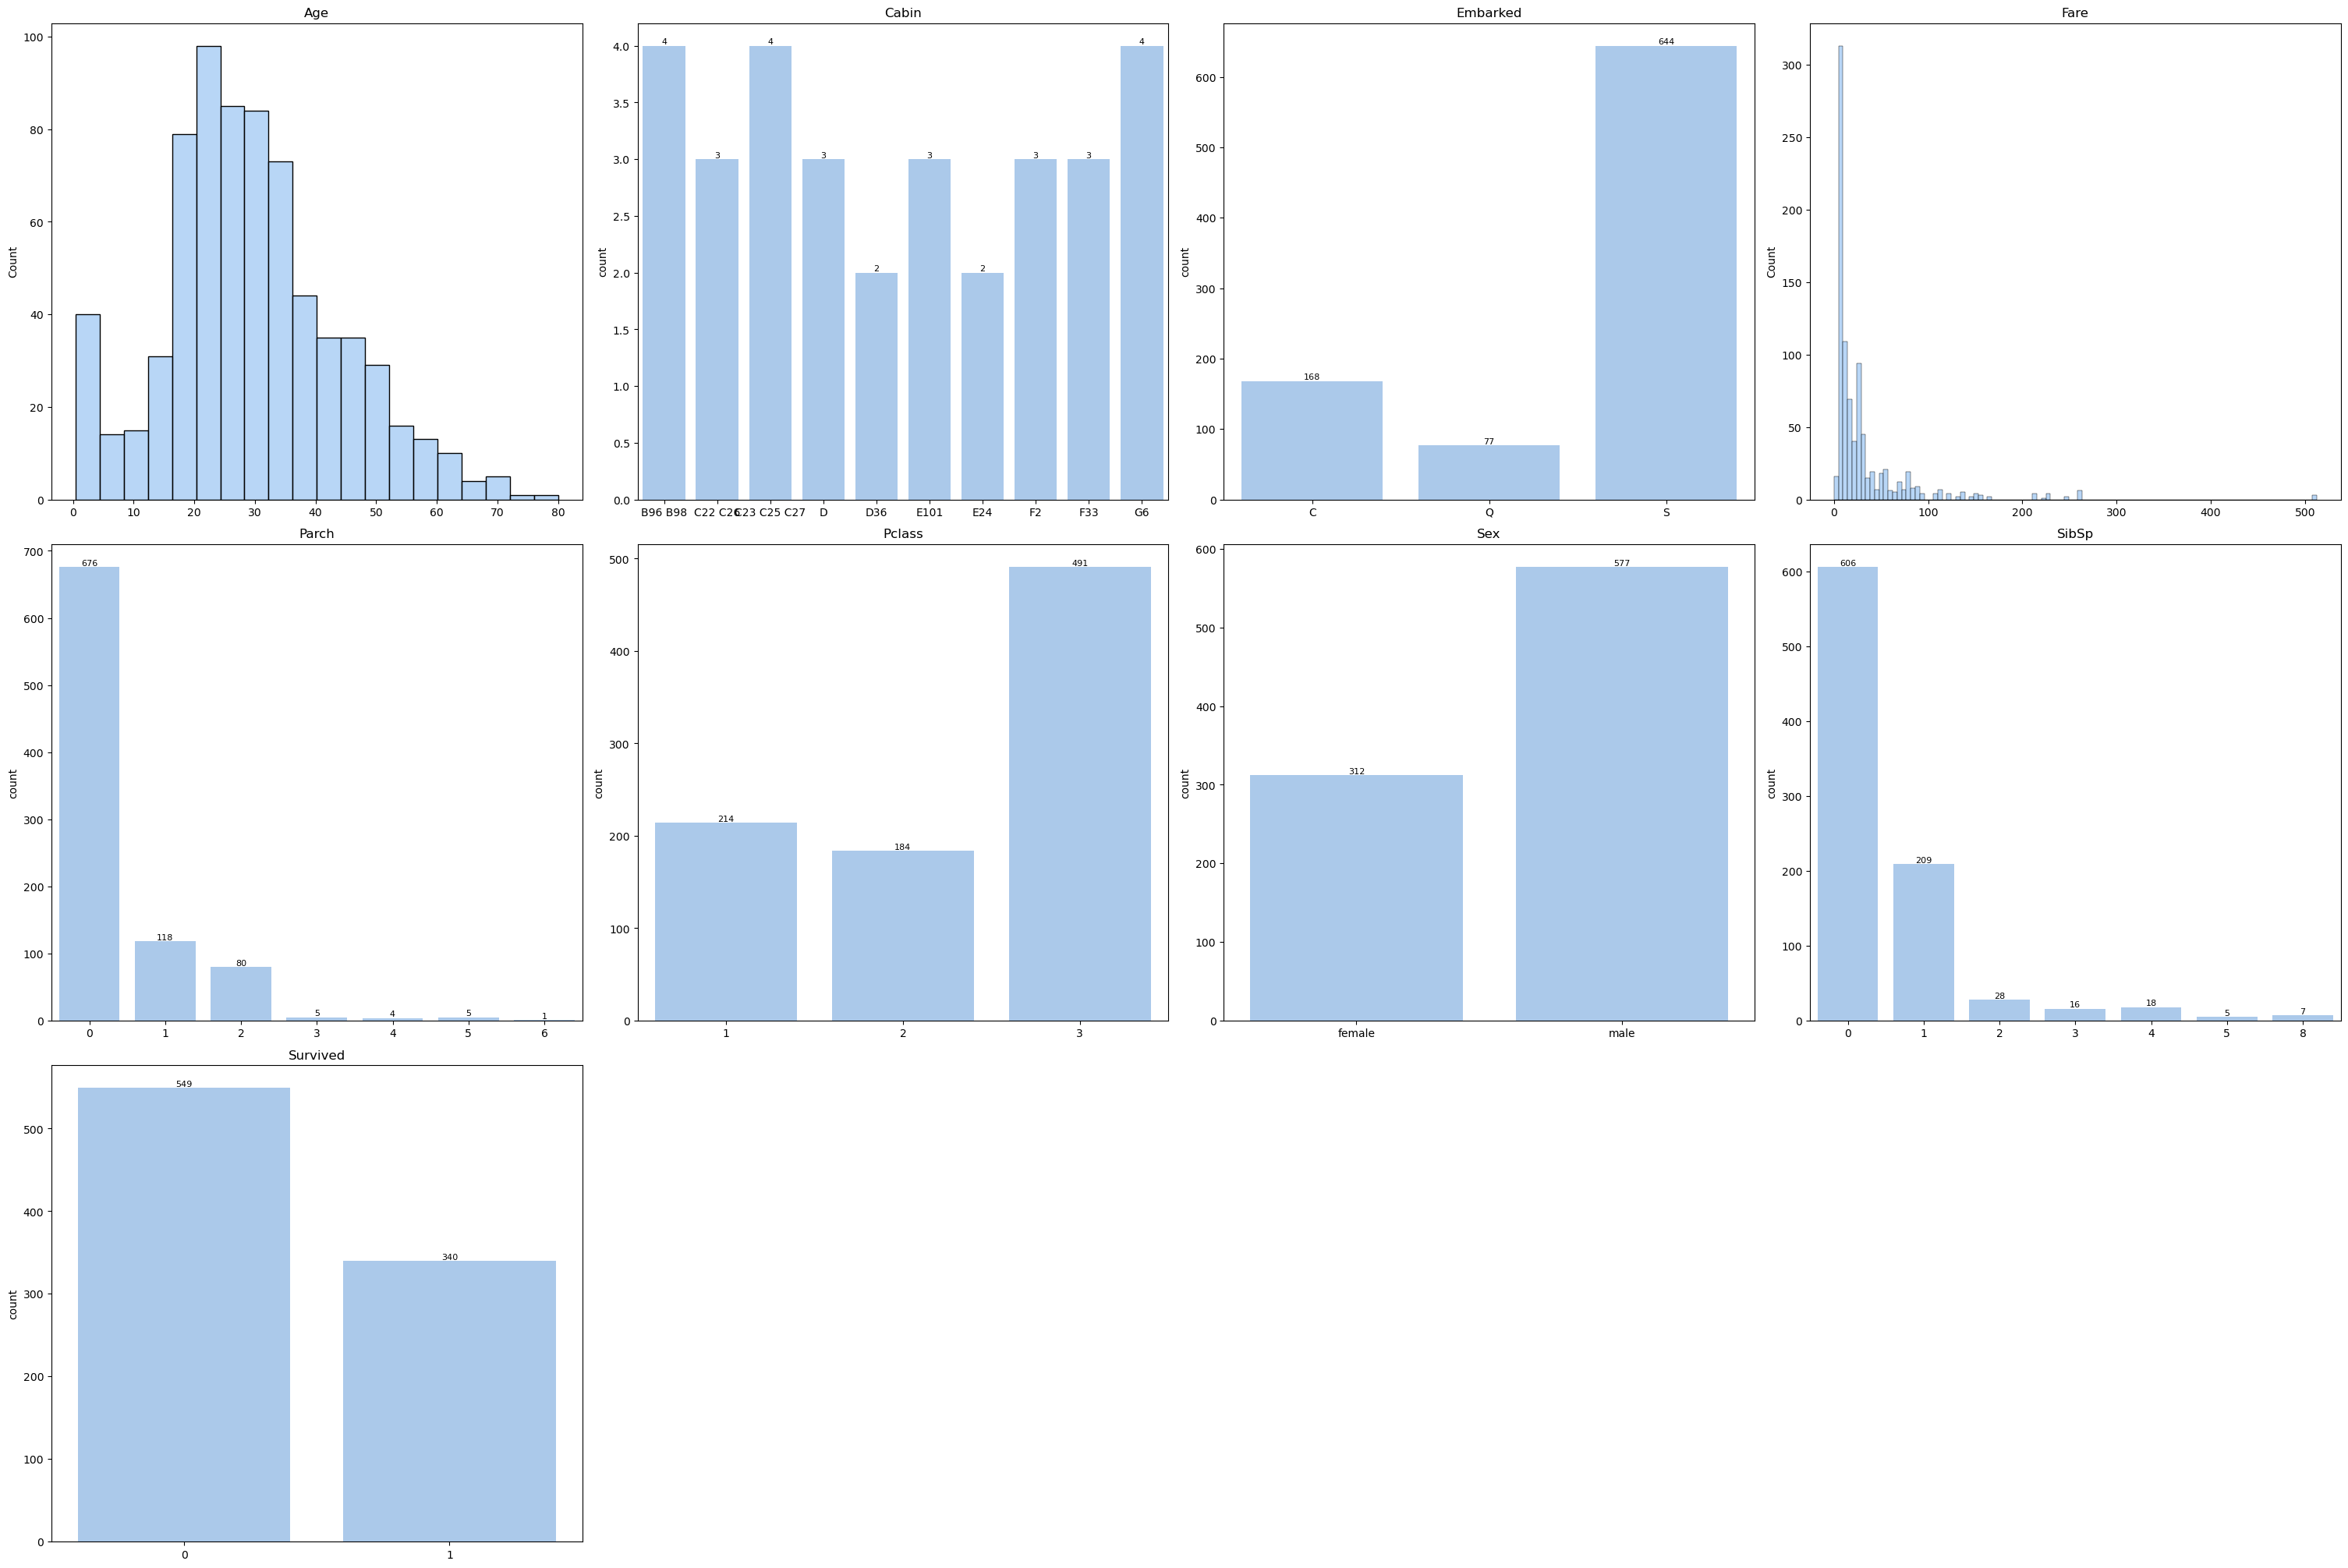

In [58]:
from modules.eda.plots import Exploratory

sns.set_palette("pastel")

feature_columns = list(set(train.columns).difference(set(['PassengerId','Name','Ticket'])))
feature_columns = sorted(feature_columns, key=str.casefold)

Exploratory(figsize = (30,20), ncol = 4, df = train[feature_columns]).plot()


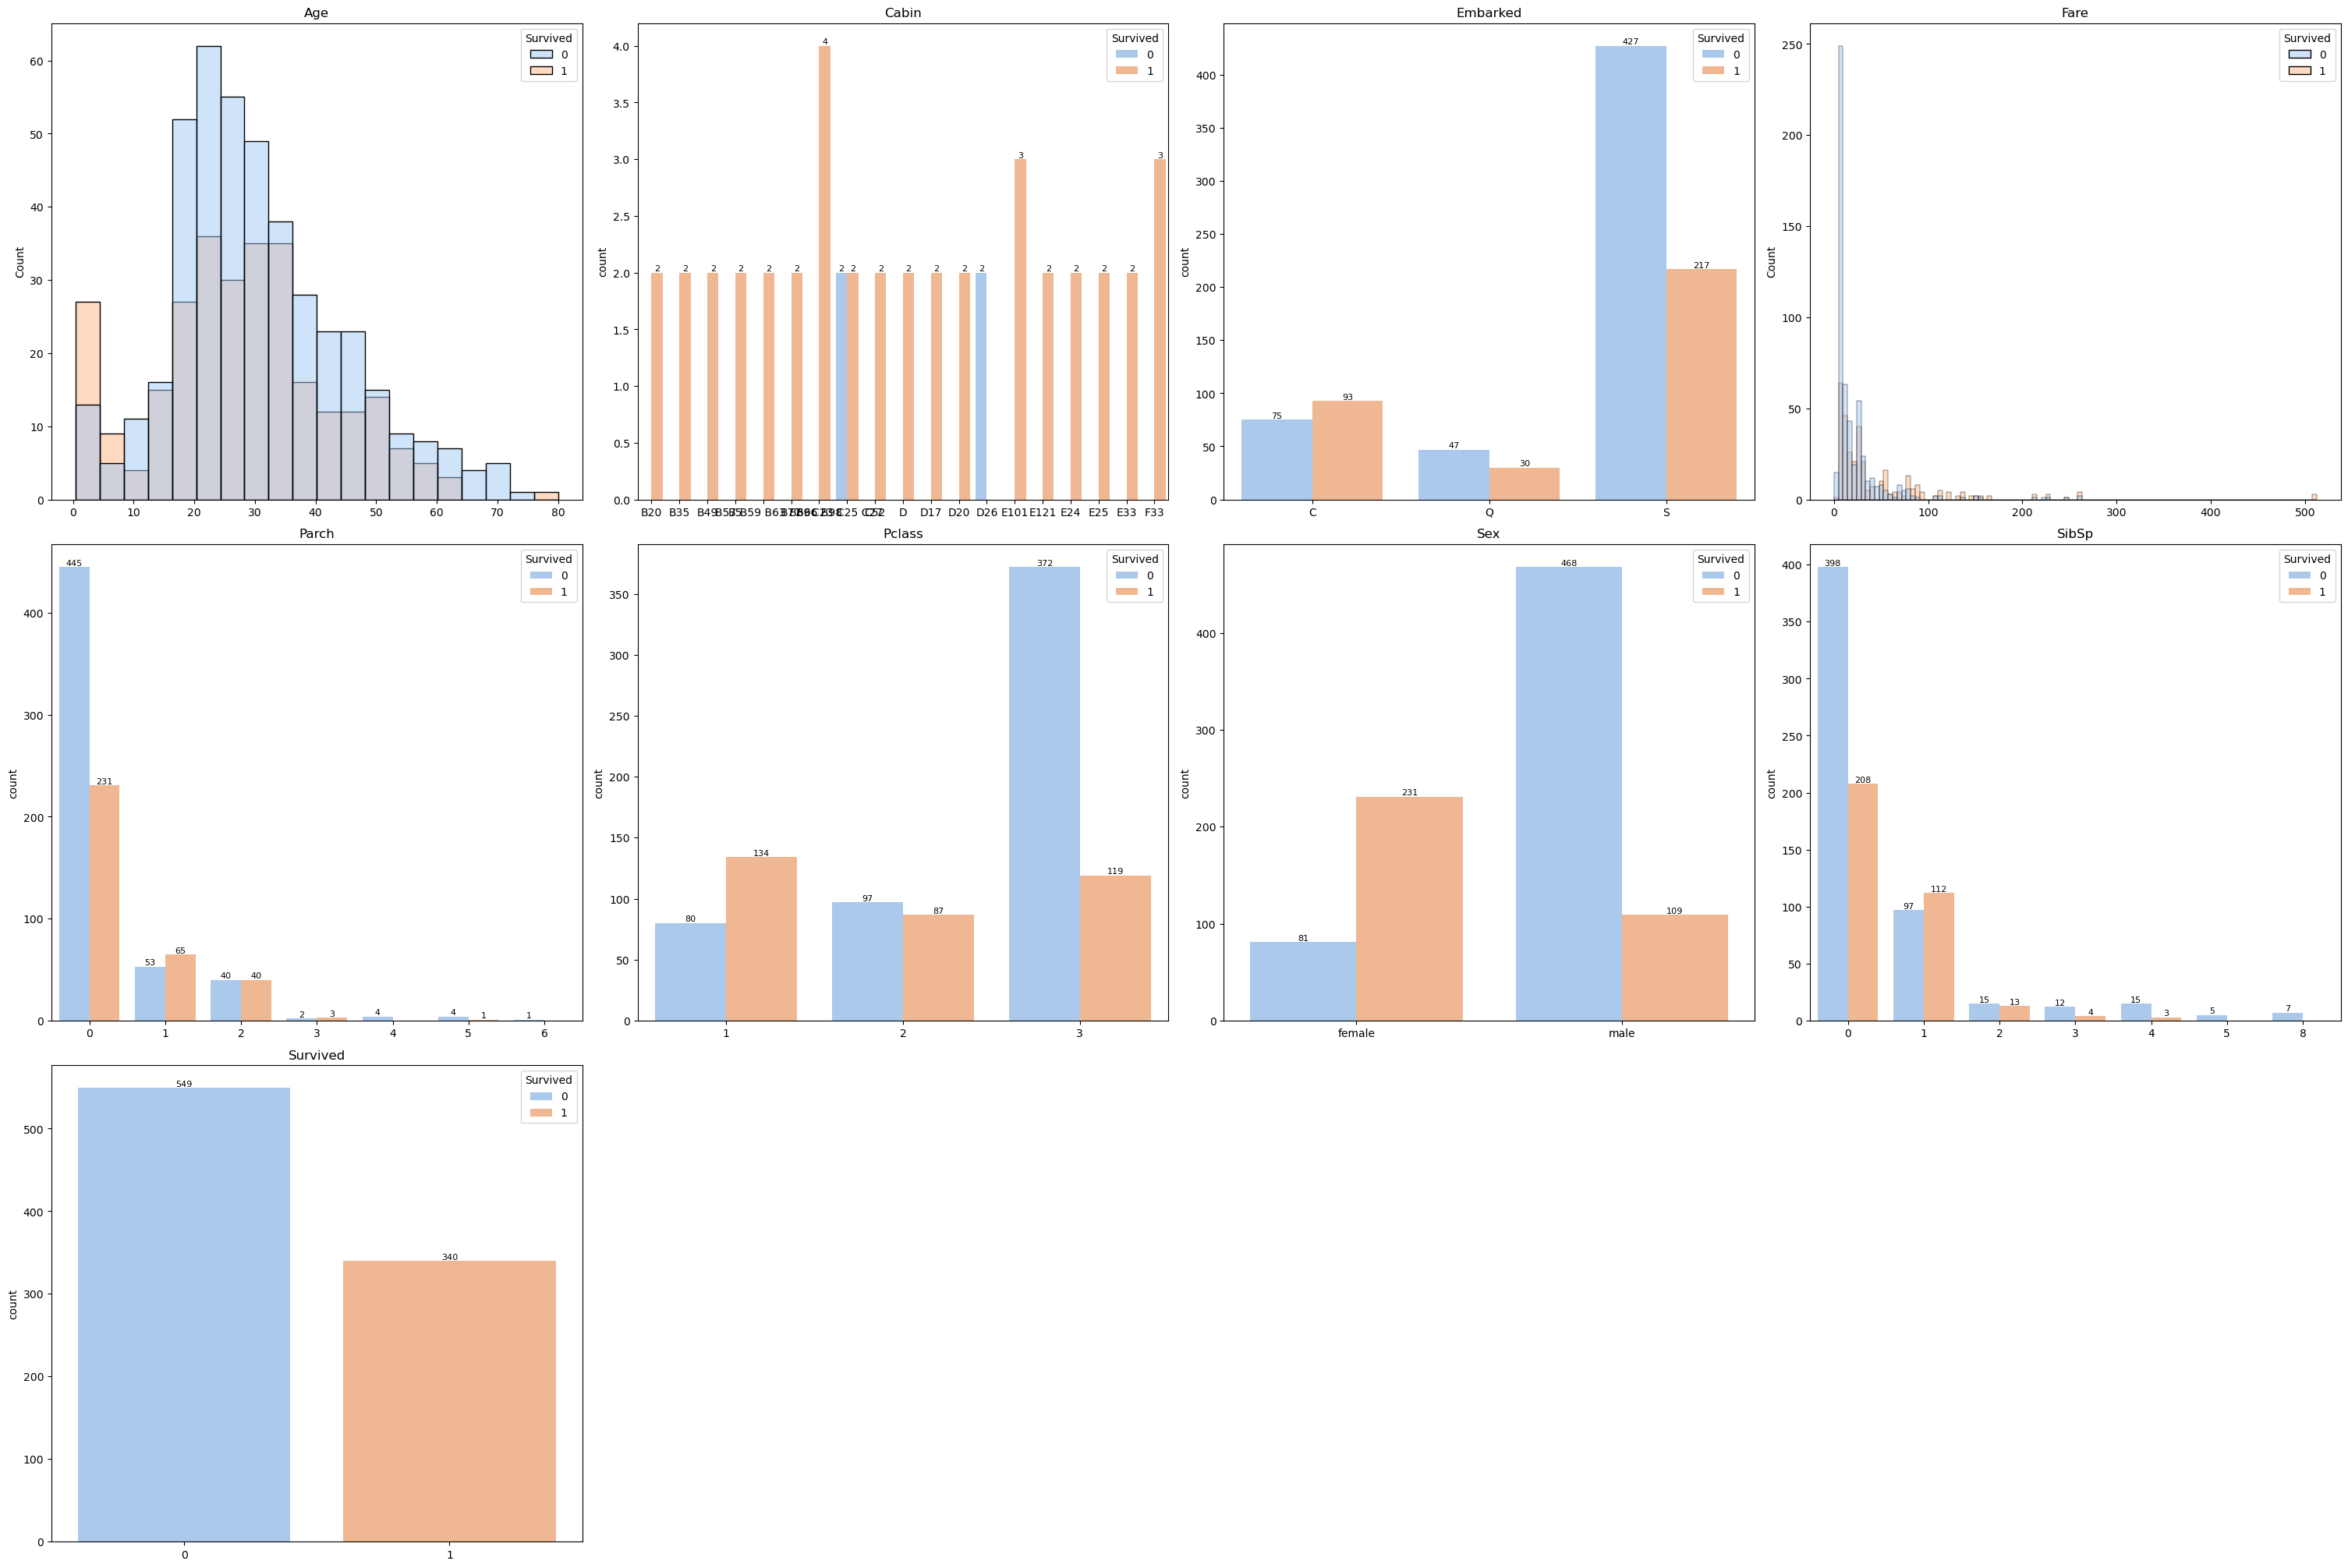

In [59]:
Exploratory(figsize = (30,20), ncol = 4, df = train[feature_columns], hue='Survived').plot()

**dropping column**
- cabin_share_flg : similar to cabin_flg but separates has_cabin to private & shared. This division make some pairs too ganular so it seems to be better to drop cabin_share_flg
- cabin_count : data is too imbalanced. Also it looks like the survival rate seems greater for cabin_count>0, which mean cabin_flg seems to be enough to account for the impact
- name_title : data is too imbalanced.

Should SibSp and Parch be dropped since they are imbalanced as well? Can family flag take account for the impact of SibSp and Parch?

In [63]:
Exploratory(figsize = (100,100), df = train[feature_columns], y='all', hue='Survived').plot()

/opt/miniconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


revisiting check list
- ticket_share_flg related to
    - family_flg?: O
    - cabin_flg?: X
    - cabin_share_flg: X

It looks like survival Parch vs no Parch has more impact than SibSp vs no SibSp (in Parch vs SibSp graph, survivor proportion rise when Parch>0 even for SibSp=0). Also, according to family_flg vs Survived, having no family onboard greatly affects one's survival as well.
Thus, SibSp and Parch will be replaced. But is family_flg enough? Or will it be better to use SibSp_flg, Parch_flg and their interactions? (no_family_flg, big_family_flg)


In [61]:
def get_sibsp_flg(X):
    X = X.copy()
    X['sibsp_flg'] = [0 if x==0 else 1 for x in X.iloc[:,0]]
    return X[['sibsp_flg']]

def get_parch_flg(X):
    X = X.copy()
    X['parch_flg'] = [0 if x==0 else 1 for x in X.iloc[:,0]]
    return X[['parch_flg']]

def get_no_family_flg(X):
    X = X.copy()
    X['no_family_flg'] = X.apply(lambda x: 1 if ((x['SibSp']==0) & (x['Parch']==0)) else 0, axis=1)
    return X[['no_family_flg']]

def get_big_family_flg(X):
    X = X.copy()
    X['big_family_flg'] = X.apply(lambda x: 1 if ((x['SibSp']>0) & (x['Parch']>0)) else 0, axis=1)
    return X[['big_family_flg']]


train['sibsp_flg'] = get_sibsp_flg(train[['SibSp']])
train['parch_flg'] = get_parch_flg(train[['Parch']])
train['no_family_flg'] = get_no_family_flg(train[['SibSp','Parch']])
train['big_family_flg'] = get_big_family_flg(train[['SibSp','Parch']])

print(train['sibsp_flg'].value_counts(), 
      train['parch_flg'].value_counts(),
      train['no_family_flg'].value_counts(),
      train['big_family_flg'].value_counts(),
      sep='\n')


sibsp_flg
0    606
1    283
Name: count, dtype: int64
parch_flg
0    676
1    213
Name: count, dtype: int64
no_family_flg
1    535
0    354
Name: count, dtype: int64
big_family_flg
0    747
1    142
Name: count, dtype: int64


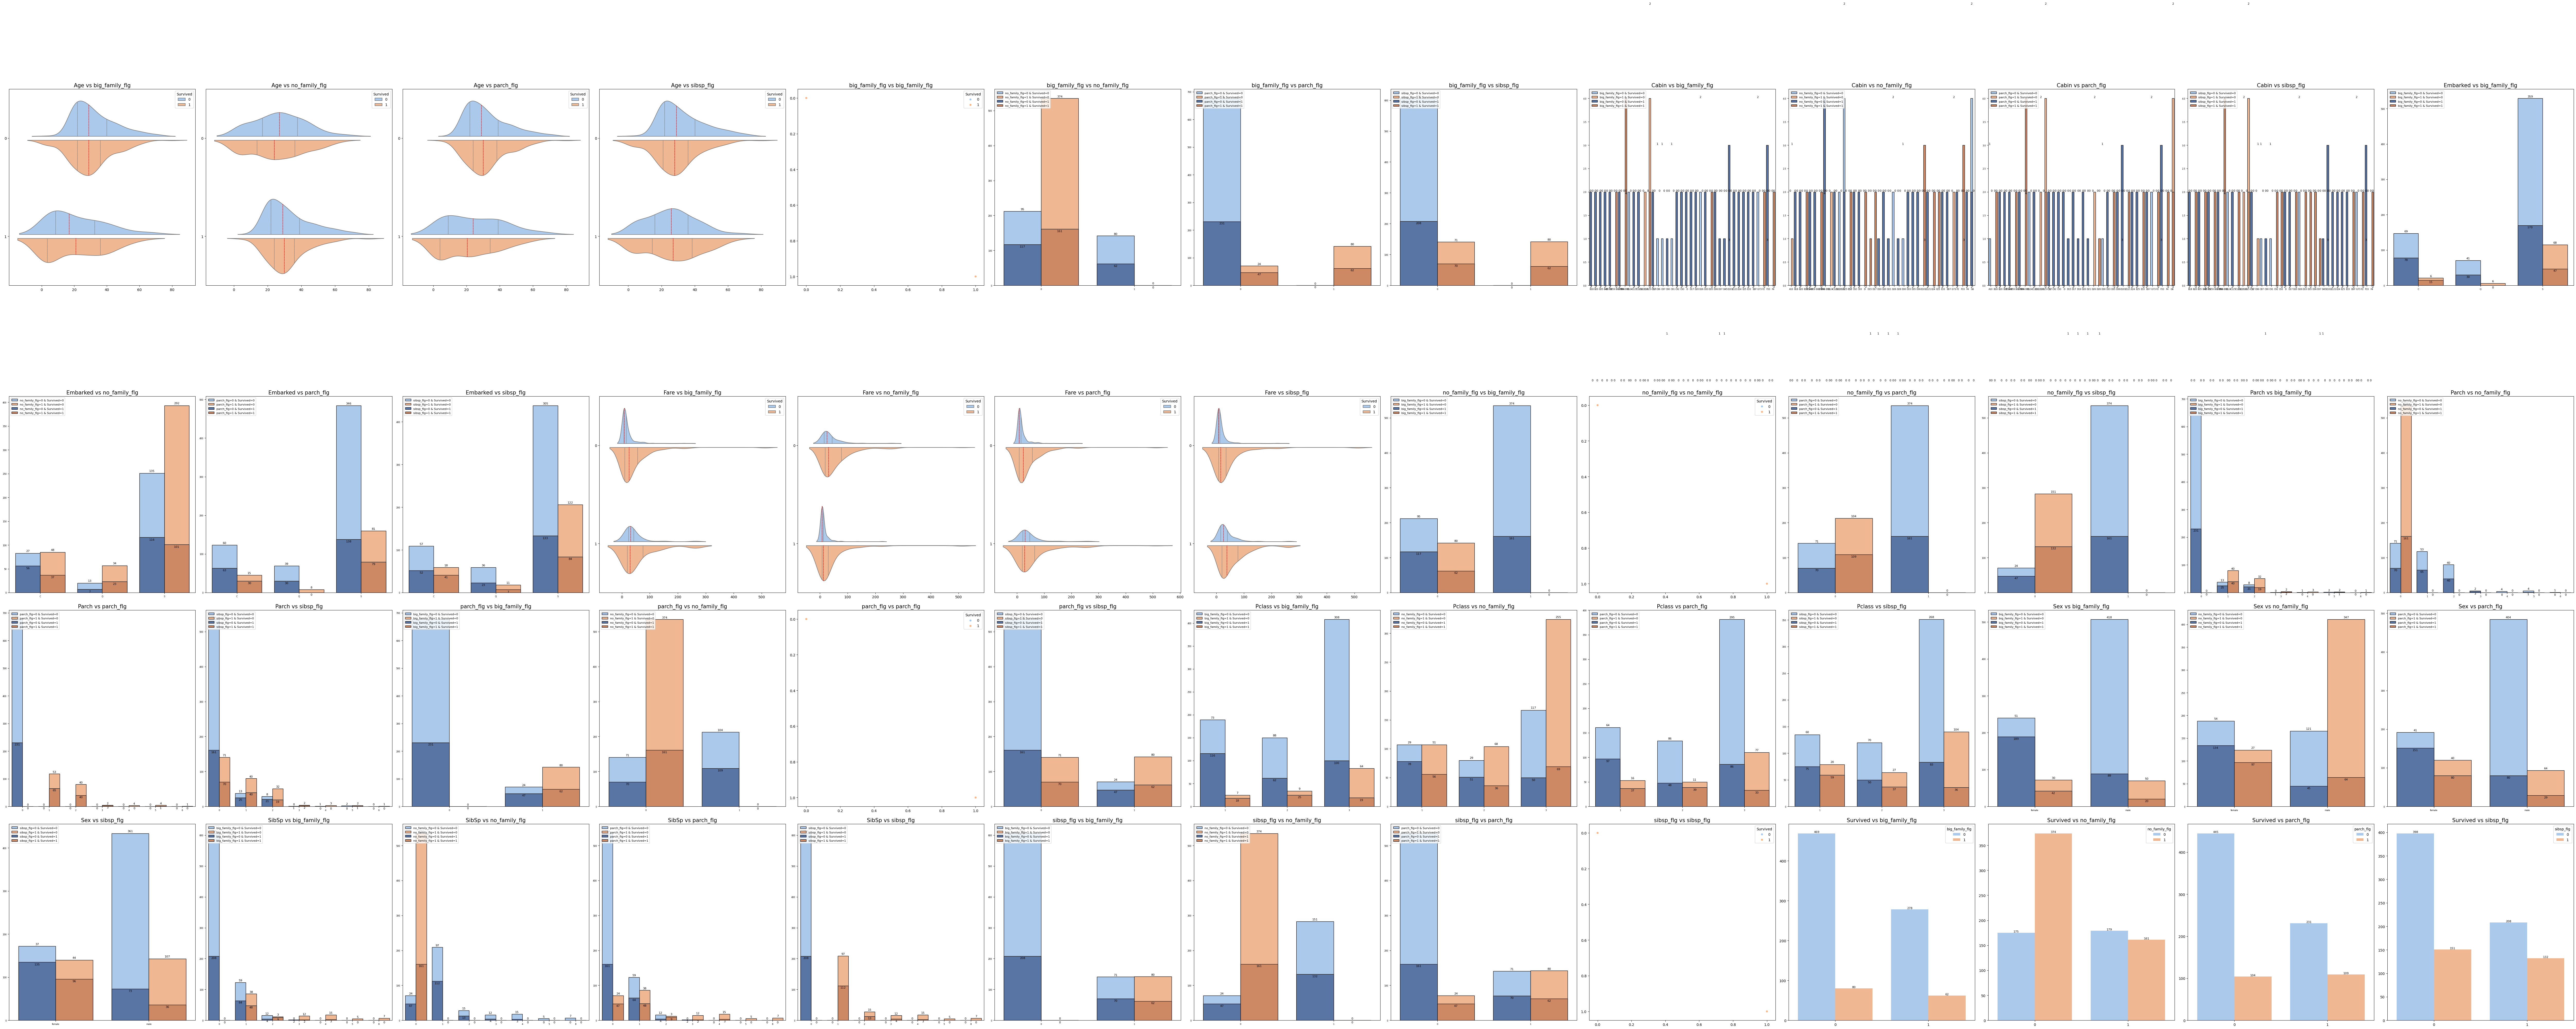

In [62]:
feature_columns = list(set(train.columns).difference(set(['PassengerId','Name','Ticket'])))
feature_columns = sorted(feature_columns, key=str.casefold)
Exploratory(figsize = (100,40), df = train[feature_columns], x='all', y=['parch_flg', 'sibsp_flg', 'no_family_flg', 'big_family_flg', 'family_flg'], hue='Survived').plot()

In [43]:
feature_func = feature_func + [('get_sibsp_flg', 'SibSp'),
                               ('get_parch_flg', 'Parch'),
                               ('get_no_family_flg', ['SibSp','Parch']),
                               ('get_big_family_flg', ['SibSp','Parch'])]
feature_func

[('get_special_title_flg', 'Name'),
 ('get_name_title', 'Name'),
 ('get_family_flg', ['SibSp', 'Parch']),
 ('get_cabin_count', 'Cabin'),
 ('get_cabin_flg', 'Cabin'),
 ('get_cabin_share_flg', 'Cabin'),
 ('get_ticket_share_flg', 'Ticket'),
 ('get_age_flg', 'Age'),
 ('get_fare_flg', 'Fare'),
 ('get_sibsp_flg', 'SibSp'),
 ('get_parch_flg', 'Parch'),
 ('get_no_family_flg', ['SibSp', 'Parch']),
 ('get_big_family_flg', ['SibSp', 'Parch'])]

**Possible interaction:**
- Age x cabin_flg : has_cabin & not survived has higher median age
- ~~Age x Embarked: Q & survived has lower median age~~
- Age x family_flg : parch & not survived has higher median age
- Age x Pclass : 1st class & not survived has higher median age
- ~~cabin_flg x Embarked : embarked from Cherbourg (C) and having a cabin has higher survival~~
- cabin_flg x family_flg : SibSp & big_fam seems to have higher chance of survival for has_cabin compared to Parch and no_fam with has_cabin
- cabin_flg x Fare : survived passengers with has_cabin seems to have higher Fare
- cabin_flg x Pclass : 1st and 2nd class without cabin has higher proportion of survivors (due to small data point available, just add Pclass1:cabin_flg interaction)
- cabin_flg x Sex: has_cabin & female has higher survival 
- ~~cabin_flg x special_title_flg : has_cabin & special title has higher survival~~
- ~~cabin_flg x ticket_share_flg : has_cabin & shared has higher survival~~
- Embarked x family_flg : passengers with families from C port have higher chance of survival (due to small data point availabile, just add no_fam:Embarked interaction)
- Embarked x Fare : survivors from C port had higher median fare
- Embarked x Pclass : survival rate of 1st class passenger from port C seem to be the highest (due to small data point available, just add Pclass3:Embarked interaction)
- Embarked x ticket_share_flg : passengers with shared ticket from port C seem to have higher survival compared to others from different port
- Fare x family_flg : survivors with just siblings seem to spent more on their Fare than the deceased. For simplicity, we will just check the interaction between SibSp and Fare
- family_flg x Pclass : Pclass 1 with no family has the lowest survival amongst other family_flg
- family_flg x ticket_share_flg : shared ticket holders with Parch has highest rate or survivors
- Pclass x Sex : effect of Sex changes between Pclass (male Pclass 1 has similar proportion of survivors compared to female Pclass 3)
- Pclass x ticket_share_flg : effect of ticket_share differs between Pclass (shared Pclass 1 holder has much higher rate of survival compared to shared Pclass 3)
- Sex x special_title_flg : male with special name title has higher survivor rate than generic name title. (due to small data point for female special name title, just add male:special_title_flg)
- Embarked x no_family_flg: same reasoning from above
- cabin_flg x big_family_flg, parch_flg, sibsp_flg : passenger with a family member and with a cabin seems to increase the survival rate
- Pclass x big_family_flg, parch_flg, sibsp_flg : passenger with a family member and with Pclass 1,2 seems to increase the survival rate


In [44]:
interaction_terms = [
    ('Age','cabin_flg'),
    ('Age','family_flg'),
    ('Age','Pclass'),
    ('cabin_flg','family_flg'),
    ('cabin_flg','Fare'),
    ('cabin_flg','Pclass_1'),
    ('cabin_flg','Sex'),
    ('Embarked','family_flg_no_fam'),
    ('Embarked','Fare'),
    ('Embarked','Pclass_3'),
    ('Embarked','ticket_share_flg'),
    ('Fare','family_flg_SibSp'),
    ('family_flg','Pclass'),
    ('family_flg','ticket_share_flg'),
    ('Pclass','Sex'),
    ('Pclass','ticket_share_flg'),
    ('Sex_male','special_title_flg'),
    ('Embarked','no_family_flg'),
    ('cabin_flg','big_family_flg'),
    ('cabin_flg','parch_flg'),
    ('cabin_flg','sibsp_flg'),
    ('Pclass','big_family_flg'),
    ('Pclass','parch_flg'),
    ('Pclass','sibsp_flg')
]

## 4) Pipeline

In [45]:
train.dtypes

PassengerId             int64
Survived                int64
Pclass                  int64
Name                   object
Sex                    object
Age                   float64
SibSp                   int64
Parch                   int64
Ticket                 object
Fare                  float64
Cabin                  object
Embarked               object
name_title           category
special_title_flg    category
family_flg           category
cabin_count             int64
cabin_flg            category
cabin_share_flg      category
ticket_share_flg     category
age_flg              category
fare_flg             category
sibsp_flg               int64
parch_flg               int64
no_family_flg           int64
big_family_flg          int64
dtype: object

The final preprocessing step would be finalizing the data type.
- Pclass : int64 -> cagetory
- Sex : object -> category 
- Embarked : object -> category

Normally, Sex would be integer value (1:male, 0:female), but to account for interaction, it will be changed to category data instead.

In [46]:
def change_to_categorical(X):
  return X.astype('category')

train['Pclass'] = change_to_categorical(train[['Pclass']])
train['Sex'] = change_to_categorical(train[['Sex']])
train['Embarked'] = change_to_categorical(train[['Embarked']])
feature_func = feature_func + [('change_to_categorical', 'Pclass'),('change_to_categorical', 'Sex'),('change_to_categorical', 'Embarked')]


In [47]:
train.dtypes

PassengerId             int64
Survived                int64
Pclass               category
Name                   object
Sex                  category
Age                   float64
SibSp                   int64
Parch                   int64
Ticket                 object
Fare                  float64
Cabin                  object
Embarked             category
name_title           category
special_title_flg    category
family_flg           category
cabin_count             int64
cabin_flg            category
cabin_share_flg      category
ticket_share_flg     category
age_flg              category
fare_flg             category
sibsp_flg               int64
parch_flg               int64
no_family_flg           int64
big_family_flg          int64
dtype: object

In [48]:
feature_func

[('get_special_title_flg', 'Name'),
 ('get_name_title', 'Name'),
 ('get_family_flg', ['SibSp', 'Parch']),
 ('get_cabin_count', 'Cabin'),
 ('get_cabin_flg', 'Cabin'),
 ('get_cabin_share_flg', 'Cabin'),
 ('get_ticket_share_flg', 'Ticket'),
 ('get_age_flg', 'Age'),
 ('get_fare_flg', 'Fare'),
 ('get_sibsp_flg', 'SibSp'),
 ('get_parch_flg', 'Parch'),
 ('get_no_family_flg', ['SibSp', 'Parch']),
 ('get_big_family_flg', ['SibSp', 'Parch']),
 ('change_to_categorical', 'Pclass'),
 ('change_to_categorical', 'Sex'),
 ('change_to_categorical', 'Embarked')]

revisiting check list
- family_flg vs sibsp_flg, parch_flg, no_family_flg, big_family_flg and their interactions?

In [49]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from modules.preproc.LogisticRegression import LogOddsTransformer, InteractionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from modules.preproc.AutoImputer import SkewBasedImputer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

def feature_transformer(X):
    def no_transform(X):
        return X
    
    out_trans = []
    
    for tup in X:
        if isinstance(tup[1],list):
            feature_in = tup[1]
        else:
            feature_in = [tup[1]]
        if 'change' in tup[0]:
            f = (tup[1], FunctionTransformer(eval(tup[0])).set_output(transform="pandas"), feature_in)
        else:
            colname = tup[0].replace('get_', '')  
            f = (colname, FunctionTransformer(eval(tup[0])).set_output(transform="pandas"), feature_in)
        out_trans.append(f)
    
    for col in ['Age','Fare']:
        f = (col, FunctionTransformer(no_transform).set_output(transform="pandas"), [col])
        out_trans.append(f)
    
    return out_trans

train = pd.read_csv("./data/train.csv")
train = train.loc[~train['Embarked'].isna()]

X = train.drop(['Survived','PassengerId'],axis=1)
y = train['Survived']


## Logistic Regression

### family_flg

In [50]:
feature_func_v1 = [f for f in feature_func if (f[0] not in ['get_name_title','get_no_family_flg','get_big_family_flg','get_parch_flg','get_sibsp_flg', 'get_cabin_share_flg', 'get_cabin_count'])]
interaction_terms_v1 = [t for t in interaction_terms if ((t[0] not in ['no_family_flg','big_family_flg','parch_flg','sibsp_flg'])&(t[1] not in ['no_family_flg','big_family_flg','parch_flg','sibsp_flg'])) ]
categorical_features_v1 = ['family_flg', 'Pclass', 'Sex', 'Embarked', 'special_title_flg', 'cabin_flg', 'ticket_share_flg', 'age_flg', 'fare_flg']
continuous_features_v1 = ['Age', 'Fare']

data_preprocessing_v1 = ColumnTransformer(
    transformers=feature_transformer(feature_func_v1)
    ,remainder = 'passthrough'
    ,verbose_feature_names_out=False
)
data_preprocessing_v1.set_output(transform='pandas')

categorical_feature_cleaning_v1 = Pipeline([
        ('one-hot encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

continuous_feature_cleaning_v1 = Pipeline([
        ('logodds', LogOddsTransformer(max_iter=7)),
        ('scaler', StandardScaler()),
        ('impute', SkewBasedImputer())
    ])

feature_cleaning_v1 = ColumnTransformer(
        transformers=[
            ('cont_pipeline', continuous_feature_cleaning_v1, continuous_features_v1)
            ,('cat_pipeline', categorical_feature_cleaning_v1, categorical_features_v1)
        ]
        , verbose_feature_names_out=False
        , remainder = 'passthrough'
    )
feature_cleaning_v1.set_output(transform='pandas')

preprocessing_pipeline_v1 = Pipeline([
    ('data_preprocessing', data_preprocessing_v1)
    ,('feature_cleaning', feature_cleaning_v1)
    ,('interaction', InteractionTransformer(interaction_terms_v1))
])

logit_pipeline_v1 = Pipeline([
    ('preprocessing', preprocessing_pipeline_v1)
    ,('model', LogisticRegression(penalty='l1', solver='liblinear'))
])

cv = 7
scoring = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}
scores_v1 = cross_validate(logit_pipeline_v1, X, y, scoring=scoring, cv=cv)
output_v1 = {'model':'Logistic_family_flg_l1'}
for score_name, scores in scores_v1.items():
    output_v1[score_name] = np.mean(scores)

output_df_v1 = pd.DataFrame([output_v1])
output_df_v1


/opt/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


model  fit_time  score_time  test_acc  test_precision  \
0  Logistic_family_flg_l1  0.124948    0.133568  0.808774        0.793903   

   test_recall   test_f1  test_roc_auc  
0       0.6793  0.729238       0.85777

### big_family_flg, no_family_flg, parch_flg, sibsp_flg

In [51]:
feature_func_v2 = [f for f in feature_func if (f[0] not in ['get_name_title','get_family_flg', 'get_cabin_share_flg', 'get_cabin_count'])]
interaction_terms_v2 = [t for t in interaction_terms if ((t[0] not in ['family_flg', 'family_flg_no_fam', 'family_flg_SibSp'])&(t[1] not in ['family_flg', 'family_flg_no_fam', 'family_flg_SibSp'])) ]
categorical_features_v2 = ['Pclass', 'Sex', 'Embarked', 'special_title_flg', 'cabin_flg', 'ticket_share_flg', 'age_flg', 'fare_flg']
continuous_features_v2 = ['Age', 'Fare']

data_preprocessing_v2 = ColumnTransformer(
    transformers=feature_transformer(feature_func_v2)
    ,remainder = 'passthrough'
    ,verbose_feature_names_out=False
)
data_preprocessing_v2.set_output(transform='pandas')

categorical_feature_cleaning_v2 = Pipeline([
        ('one-hot encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

continuous_feature_cleaning_v2 = Pipeline([
        ('logodds', LogOddsTransformer(max_iter=7)),
        ('scaler', StandardScaler().set_output(transform="pandas")),
        ('impute', SkewBasedImputer())
    ])

feature_cleaning_v2 = ColumnTransformer(
        transformers=[
            ('cont_pipeline', continuous_feature_cleaning_v2, continuous_features_v2)
            ,('cat_pipeline', categorical_feature_cleaning_v2, categorical_features_v2)
        ]
        , verbose_feature_names_out=False
        , remainder = 'passthrough'
    )
feature_cleaning_v2.set_output(transform='pandas')

preprocessing_pipeline_v2 = Pipeline([
    ('data_preprocessing', data_preprocessing_v2)
    ,('feature_cleaning', feature_cleaning_v2)
    ,('interaction', InteractionTransformer(interaction_terms_v2))
])

logit_pipeline_v2 = Pipeline([
    ('preprocessing', preprocessing_pipeline_v2)
    ,('model', LogisticRegression(penalty='l1', solver='liblinear'))
])

cv = 7
scoring = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}
scores_v2 = cross_validate(logit_pipeline_v2, X, y, scoring=scoring, cv=cv)
output_v2 = {'model':'Logistic_non-family_flg_l1'}
for score_name, scores in scores_v2.items():
    output_v2[score_name] = np.mean(scores)

output_df_v2 = pd.DataFrame([output_v2])
output_df_v2


/opt/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


model  fit_time  score_time  test_acc  test_precision  \
0  Logistic_non-family_flg_l1  0.190433    0.154255  0.814398        0.804675   

   test_recall  test_f1  test_roc_auc  
0     0.682276  0.73558      0.854458

In [52]:
logit_pipeline_v3 = Pipeline([
    ('preprocessing', preprocessing_pipeline_v1)
    ,('model', LogisticRegression(penalty='l2', solver='liblinear'))
])
logit_pipeline_v4 = Pipeline([
    ('preprocessing', preprocessing_pipeline_v2)
    ,('model', LogisticRegression(penalty='l2', solver='liblinear'))
])
scores_v3 = cross_validate(logit_pipeline_v3, X, y, scoring=scoring, cv=cv)
scores_v4 = cross_validate(logit_pipeline_v4, X, y, scoring=scoring, cv=cv)

output_v3 = {'model':'Logistic_family_flg_l2'}
for score_name, scores in scores_v3.items():
    output_v3[score_name] = np.mean(scores)
output_df_v3 = pd.DataFrame([output_v3])
output_v4 = {'model':'Logistic_non-family_flg_l2'}
for score_name, scores in scores_v4.items():
    output_v4[score_name] = np.mean(scores)
output_df_v4 = pd.DataFrame([output_v4])


In [53]:
pd.concat([output_df_v1,output_df_v2,output_df_v3,output_df_v4], axis=0, ignore_index=True)

model  fit_time  score_time  test_acc  test_precision  \
0      Logistic_family_flg_l1  0.124948    0.133568  0.808774        0.793903   
1  Logistic_non-family_flg_l1  0.190433    0.154255  0.814398        0.804675   
2      Logistic_family_flg_l2  0.145240    0.145877  0.813273        0.791679   
3  Logistic_non-family_flg_l2  0.117813    0.120050  0.814398        0.802500   

   test_recall   test_f1  test_roc_auc  
0     0.679300  0.729238      0.857770  
1     0.682276  0.735580      0.854458  
2     0.699951  0.740034      0.856083  
3     0.685070  0.736521      0.850881

Based on this result, Logistic_family_flg_l2 model seems to be the best. It has the highest roc_auc, f1, and 2nd best accuracy

In [54]:
logit_pipeline_v3.fit(X,y)
test_X = test.drop(['PassengerId'],axis=1)
y_test_pred = logit_pipeline_v3.predict(test_X)

In [55]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_test_pred
})
submission.to_csv('/Users/Amy/Downloads/submission.csv', index=False)

Kaggle submission score = 0.78708